# Task 2 - Corners

In [ ]:
import os
import json
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import chi2_contingency
import numpy as np
from mplsoccer import Pitch
from matplotlib.patches import Rectangle

YARDS_TO_METER = 0.9144

## Preprocessing

The goal of this step to create a new json containing only the actual corners from each match. Basically what happens that we first iterate over all json files and save all corners and events from corners (as I was not sure whether I needed them) in a file. As this is too large too analyze we then extract only the actual corners in a new file. Additionally we added the match id to each event to have this information as well (using the file name). Moreover, we created another json containing the most important match infos of each match in the dataset. Last, as by Statsbomb definition almost all corners are passes we removed the few shots (around 30 from the over 30.000 corners) to make the analysis simpler. The few shots are too few to generate any significant knowledge. Overall the following are created in this process:
- corner_event.json: containing all corner-related events (corners and events after a corner) from all matches in the dataset
- only_corner_events.json: containing only the corner events from all matches in the dataset
- corner_shots_events.json: contaning all information from the few corners that are shots from all matches in the dataset
- corner_pass_events.json: containing all information from the (almost all) corners that are passes from all matches in the dataset
- all_matches.json: containing the basic information from all matches in the dataset in one file
- all_360_corners: containing the position data for each corner along with basic information of each corner for all three-sixty matches (excpect three matches where the three-sixty data was corrupted, which however should not influence the results in a meaningful way)

In [ ]:
# Function to process a single JSON file and extract relevant corner events and corner-related events
def process_json_file(file_path, match_id):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        corner_events = []

        # Loop through each event in the file
        for event in data:
            # Check if the event is related to a corner based on pass, shot, or play_pattern
            if 'pass' in event and 'type' in event['pass'] and event['pass']['type']['id'] == 61:  # Corner Pass
                event['match_id'] = match_id
                corner_events.append(event)
            elif 'shot' in event and 'type' in event['shot'] and event['shot']['type']['id'] == 61:  # Corner Shot
                event['match_id'] = match_id
                corner_events.append(event)
            elif 'play_pattern' in event and event['play_pattern']['id'] == 2:  # Play Pattern from Corner
                event['match_id'] = match_id
                corner_events.append(event)

        return corner_events


# Main function to loop through all files and collect corner events
def process_event_files(folder_path):
    all_corner_events = []

    # Loop through each file in the directory
    for subdir, _, files in os.walk(folder_path):
        for i, file in enumerate(files):
            if file.endswith('.json'):
                if i%100 == 0:
                    print(i, 100*(i/3434))
                match_id = os.path.splitext(file)[0]  # Extract match ID from filename
                file_path = os.path.join(subdir, file)
                corner_events = process_json_file(file_path, match_id)
                all_corner_events.extend(corner_events)  # Collect all corner events

    return all_corner_events


# Specify the path to the folder containing the event JSON files
folder_path = 'data/events'

# Process all files and get corner events
all_corner_events = process_event_files(folder_path)

# Save the corner events to a new JSON file
with open('corner_events.json', 'w') as outfile:
    json.dump(all_corner_events, outfile, indent=4)

total_events = len(all_corner_events)
print(f"Total number of corner-related events saved: {total_events}")

print(f"All corner-related events saved to 'corner_events.json'")

In [ ]:
#extarcting only the specific corner events from the previous generated file (based on the time constraints of the task it is not  to analyze the events after a corner)
file_path = 'corner_events.json'

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)
    corner_events = []

    # Loop through each event in the file
    for i, event in enumerate(data):
        # Check if the event is related to a corner based on pass, shot, or play_pattern
        if 'pass' in event and 'type' in event['pass'] and event['pass']['type']['id'] == 61:  # Corner Pass
            corner_events.append(event)
        elif 'shot' in event and 'type' in event['shot'] and event['shot']['type']['id'] == 61:  # Corner Shot
            corner_events.append(event)

# Save the corner events to a new JSON file
with open('only_corner_events.json', 'w') as outfile:
    json.dump(corner_events, outfile, indent=4)

In [ ]:
#creating a file that contains all relevant information from all matches in one file instead of being distributed over several files and folders
def process_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        match_data = {}
        for match in data:
            match_id = match['match_id']
            match_info = {
                'match_date': match['match_date'],
                'season_id': match['season']['season_id'],
                'season_name': match['season']['season_name'],
                "competition_id": match['competition']['competition_id'],
                "country_name": match['competition']['country_name'],
                "competition_name": match['competition']['competition_name'],
                "gender": match['home_team']['home_team_gender']
            }
            match_data[match_id] = match_info
        return match_data


# Main function to iterate over folders and files
def process_matches_folder(folder_path):
    all_matches = {}

    # Walk through each subfolder and file in the main folder
    for subdir, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(subdir, file)
                match_data = process_json_file(file_path)
                all_matches.update(match_data)

    # Save all matches to a single JSON file
    output_file = 'all_matches.json'
    with open(output_file, 'w') as outfile:
        json.dump(all_matches, outfile, indent=4)
    print(f'All matches have been saved to {output_file}')


# Specify the path to the folder containing the subfolders and JSON files
folder_path = 'data/matches'
process_matches_folder(folder_path)

In [ ]:
#creating a file with only corner passes to avoid having to deal with the very few corner (around 30 of over 30.000) shots in all following analyses and saving them
#in a extra file, which will be the basis for all analyses in Task 2a)
with open('only_corner_events.json', 'r') as f:
    corner_events = json.load(f)

# Filter only the shot events
shot_events = [event for event in corner_events if event['type']['name'] == 'Shot']
pass_events = [event for event in corner_events if event['type']['name'] == 'Pass']

# Save the shot events to a new JSON file
with open('corner_shot_events.json', 'w') as outfile:
    json.dump(shot_events, outfile, indent=4)
with open('corner_pass_events.json', 'w') as outfile:
    json.dump(pass_events, outfile, indent=4)

print(f"Total number of corner shots: {len(shot_events)}")
print(f"Total number of corner shots: {len(pass_events)}")

In [ ]:
#creating a file containing all information on the corners from the three-sixty matches (position data + information on the corner)

# File paths and directories
corners_file = 'corner_pass_events.json'
matches_dir = 'data/three-sixty'
output_file = 'all_360_corners.json'

# Load the corners data
with open(corners_file, 'r') as file:
    corners_data = json.load(file)

# Create a mapping of corner event IDs to their locations
corner_locations = {corner_event['id']: corner_event['location'] for corner_event in corners_data}
corner_pass_info = {corner_event['id']: corner_event['pass'] for corner_event in corners_data}

# Initialize a list to store all corner events with match IDs
all_corner_events = [] # To store the number of corners per match
corner_count = 0

# Loop through all match files in the directory
for filename in os.listdir(matches_dir):
    print(corner_count)
    if filename.endswith('.json'):
        match_id = filename.replace('.json', '')  # Extract match_id from filename
        match_file_path = os.path.join(matches_dir, filename)

        with open(match_file_path, 'r', encoding='utf-8') as match_file:
            try:
                events_data = json.load(match_file)
            except json.decoder.JSONDecodeError:
                print('Error')
                print(match_file_path)
                continue

            # Loop through events to find matches with corner events
            for event in events_data:
                event_id = event['event_uuid']
                if event_id in corner_locations:
                    # Increment the corner count for this match
                    corner_count += 1

                    # If it's a corner, append the event data with the match ID and corner location
                    corner_event_data = {
                        'match_id': match_id,
                        'event_id': event_id,
                        'freeze_frame': event.get('freeze_frame', []),
                        'location': corner_locations[event_id],  # Get the location from corners_data
                        'pass': corner_pass_info[event_id]
                    }
                    all_corner_events.append(corner_event_data)

# Write all corner events and corner counts to a new file

with open(output_file, 'w') as outfile:
    json.dump(all_corner_events, outfile, indent=4)

print(f"All corner events have been successfully extracted and saved to {output_file}.")
print(f"Corners total: {corner_count}.")

### Taking a look on the matches in the Dataset

In [ ]:
with open('all_matches.json', 'r', encoding='utf-8') as f:
    all_matches = json.load(f)

matches_per_season = defaultdict(lambda: {'male': 0, 'female': 0})
matches_per_country = defaultdict(int)
matches_per_season_country = defaultdict(lambda: defaultdict(int))

# Count the matches by season, gender, and country
for match_id, match_info in all_matches.items():
    season = match_info['season_name']
    gender = match_info['gender']
    country = match_info['country_name']

    matches_per_season[season][gender] += 1
    matches_per_country[country] += 1
    matches_per_season_country[season][country] += 1

# Sort the matches by season
sorted_seasons = sorted(matches_per_season.keys())

# Print the total number of matches
total_matches = sum(sum(gender_data.values()) for gender_data in matches_per_season.values())
print(f'Total number of matches: {total_matches}')

# Print the number of matches per season, ordered by season
for season in sorted_seasons:
    counts = matches_per_season[season]
    print(f"Season: {season}, Male: {counts['male']}, Female: {counts['female']}")

all_countries = set()
for season in matches_per_season_country:
    all_countries.update(matches_per_season_country[season].keys())
sorted_countries = sorted(all_countries)
country_counts_per_season = {country: [matches_per_season_country[season][country] for season in sorted_seasons] for country in sorted_countries}

# Prepare data for the first plot (matches per season)
male_counts = [matches_per_season[season]['male'] for season in sorted_seasons]
female_counts = [matches_per_season[season]['female'] for season in sorted_seasons]

# Plot the number of matches per season
plt.figure(figsize=(10, 6))
plt.bar(sorted_seasons, male_counts, label='Male matches', color='blue', alpha=0.6)
plt.bar(sorted_seasons, female_counts, label='Female matches', color='pink', alpha=0.6, bottom=male_counts)
plt.xlabel('Season')
plt.ylabel('Number of Matches')
plt.title('Number of Matches per Season (Male vs Female)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Prepare data for the second plot (matches per country)
sorted_countries = sorted(matches_per_country.keys(), key=lambda x: matches_per_country[x], reverse=True)
country_counts = [matches_per_country[country] for country in sorted_countries]

# Plot the number of matches per country
plt.figure(figsize=(10, 6))
plt.bar(sorted_countries, country_counts, color='green', alpha=0.7)
plt.xlabel('Country')
plt.ylabel('Number of Matches')
plt.title('Number of Matches per Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Plot the stacked bar chart for matches per season by country
plt.figure(figsize=(10, 6))

bottom_stack = [0] * len(sorted_seasons)  # Initialize the bottom stack for each season

# Add each country to the plot
for country in sorted_countries:
    counts = country_counts_per_season[country]
    plt.bar(sorted_seasons, counts, label=country, bottom=bottom_stack)
    bottom_stack = [i + j for i, j in zip(bottom_stack, counts)]  # Update bottom stack

# Configure the plot
plt.xlabel('Season')
plt.ylabel('Number of Matches')
plt.title('Number of Matches per Season (Stacked by Country)')
plt.xticks(rotation=45, ha='right')
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()

You can see that the distribution of matches in the dataset is very uneven in terms og seasons. By far the most matches in the dataset are from the season 2015/2016. This makes analyses regarding the development of corners over time very difficult as for most seasons the number of matches is too low to make significant claims with sufficient certainty.\
Moreover there are very little female matches, therefore for the sake of simplicity (and lack of time) we do not differentiate between corners in male and female matches.\
Analyses regarding the country were certainly interesting but are out of the scope of this analysis as well.

## 2a) Use the whole data set of Free Statsbomb Data to help you find general offensive trends.

### Analysing the pass height of the corners of the years
First, we want to take a look whether there is a development regrading the pass height. For example, whether there are more ground passes today than in the past

In [ ]:
with open('corner_pass_events.json', 'r') as f:
    passes = json.load(f)

# Load the match data
with open('all_matches.json', 'r') as f:
    all_matches = json.load(f)

# Initialize dictionaries to count pass heights by season
pass_heights_by_season = defaultdict(lambda: defaultdict(int))
season_total_passes = defaultdict(int)
corners_per_season = defaultdict(int)
overall_pass_heights = defaultdict(int)
total_passes_overall = 0

# Loop through passes and match each pass with its corresponding season
for event in passes:
    match_id = event['match_id']  # Assuming match_id exists in the pass data
    if match_id in all_matches:
        season = all_matches[match_id]['season_name']
        if 'pass' in event and 'height' in event['pass']:
            height_name = event['pass']['height']['name']
            pass_heights_by_season[season][height_name] += 1
            season_total_passes[season] += 1
            corners_per_season[season] += 1
            overall_pass_heights[height_name] += 1
            total_passes_overall += 1

# Prepare data for plotting (calculate percentage for each height by season)
sorted_seasons = sorted(pass_heights_by_season.keys())
corner_counts = [corners_per_season[season] for season in sorted_seasons]
heights = set(height for season in pass_heights_by_season for height in pass_heights_by_season[season])

# Convert counts to percentages
print(sum(season_total_passes.values()))
print(pass_heights_by_season.values())
percentage_by_height_season = {height: [] for height in heights}
for season in sorted_seasons:
    total_passes = season_total_passes[season]
    for height in heights:
        count = pass_heights_by_season[season].get(height, 0)
        percentage = (count / total_passes) * 100 if total_passes > 0 else 0
        percentage_by_height_season[height].append(percentage)

# Prepare data for stackplot
stack_data = [percentage_by_height_season[height] for height in heights]
height_labels = list(heights)

# Plot using stackplot
plt.figure(figsize=(10, 6))
plt.stackplot(sorted_seasons, stack_data, labels=height_labels)

# Configure the plot
plt.xlabel('Season')
plt.ylabel('Percentage of Passes')
plt.title('Percentage of Pass Heights by Season (Stacked)')
plt.xticks(rotation=45, ha='right')
plt.legend(title="Pass Height", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_seasons, corner_counts, color='skyblue')

# Add numbers above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

# Configure the plot
plt.xlabel('Season')
plt.ylabel('Number of Corners')
plt.title('Number of Corners per Season')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

seasons = sorted(pass_heights_by_season.keys())
heights = sorted({height for period_data in pass_heights_by_season.values() for height in period_data})

# Construct the contingency table
contingency_table = np.array([[pass_heights_by_season[season].get(height, 0) for height in heights] for season in seasons])

# Perform the Chi-Square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p_value}")

# Interpretation of the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The distribution of pass heights changes across periods.")
else:
    print("Fail to reject the null hypothesis: No significant change in the distribution of pass heights across periods.")

overall_percentage_by_height = {}
for height, count in overall_pass_heights.items():
    overall_percentage_by_height[height] = (count / total_passes_overall) * 100

# Print the overall percentages of pass heights
print("Overall Percentage of Pass Heights:")
for height, percentage in overall_percentage_by_height.items():
    print(f"{height}: {percentage:.2f}%")
# Show the plot
plt.show()

Even though the distribution of pass heights is fluctuating over time and Chi-Square-Test reveals that there is change in dstribution of the percantage of pass heights over time, there is no clear trend visible over time. Instead teh final plot reveals what already becam cear by looking on the number of matches over time. The number of corners per seaspmn is relatively low especially before the season 15/16 making statements regarding changes over time difficult. Nevertheless, overall 70-80% of all corners are high passes, with 15-20% of corners being ground passes. Low passes are played rarely. From a soccer point that makes sense ou either want a high pass in the box or a ground pass to a player close to the corner.

### Analysisng the pass length
Next we want to take a look on the pass lengths regading the different types of corners

In [ ]:
total_length = 0
total_passes = 0
length_by_type = defaultdict(lambda: {'total_length': 0, 'count': 0})

# Loop through passes and calculate lengths
for event in passes:
    if 'pass' in event and 'length' in event['pass']:
        pass_length = event['pass']['length']
        total_length += pass_length
        total_passes += 1

        # Check pass type and store the length in corresponding type group
        if 'height' in event['pass']:
            pass_type = event['pass']['height']['name']
            length_by_type[pass_type]['total_length'] += pass_length
            length_by_type[pass_type]['count'] += 1

# Calculate overall average length
overall_average_length = total_length / total_passes if total_passes > 0 else 0

# Calculate average length by pass type
average_length_by_type = {pass_type: (data['total_length'] / data['count']) if data['count'] > 0 else 0
                          for pass_type, data in length_by_type.items()}

# Output the results
print(f"Overall average pass length: {YARDS_TO_METER*overall_average_length:.2f} meters")

print("\nAverage pass length by type:")
for pass_type, avg_length in average_length_by_type.items():
    print(f"{pass_type}: {YARDS_TO_METER*avg_length:.2f} meters")

No surprises here, ground passes are rather short to players close to the corner, while the average high pass is around 37m long which is approx. at the goal area at the height of the first post

### Analyzing the end location of the corners

In [ ]:
end_locations_x = []
end_locations_y = []
left_end_locations_x = []
left_end_locations_y = []
right_end_locations_x = []
right_end_locations_y = []

# Loop through each corner pass and normalize the end location based on the corner side
counter_left = 0
counter_right = 0
for event in passes:
    # Get the starting location of the corner
    start_x, start_y = event['location']

    # Identify if it's a left or right corner and normalize
    if (start_x < 1 and start_y < 1) or (start_x > 119 and start_y > 79):
        # Corner from the left (either from 0,0 or 120,80)
        counter_left +=1
        if start_x > 119 and start_y > 79:
            # Transform for corners taken from 120,80
            end_x = 120 - event['pass']['end_location'][0]
            end_y = 80 - event['pass']['end_location'][1]
        else:
            # No transformation needed for corners taken from 0,0
            end_x = event['pass']['end_location'][0]
            end_y = event['pass']['end_location'][1]
        left_end_locations_x.append(end_x)
        left_end_locations_y.append(end_y)
    elif (start_x < 1 and start_y > 79) or (start_x > 119 and start_y < 1):
        # Corner from the right (either from 0,80 or 120,0)
        counter_right +=1
        if (start_x < 1 and start_y > 79):
            end_x = 120 - event['pass']['end_location'][0]
            end_y = 80 - event['pass']['end_location'][1]
            print(end_x, end_y)
            break
        else:
            # No transformation needed for corners taken from 0,0
            end_x = event['pass']['end_location'][0]
            end_y = event['pass']['end_location'][1]
        right_end_locations_x.append(end_x)
        right_end_locations_y.append(end_y)

    # Add the normalized end location to the lists
    end_locations_x.append(end_x)
    end_locations_y.append(end_y)

print(len(end_locations_x))
print(np.max(end_locations_x))
print(counter_left, counter_right)

# Create the heatmap data using numpy's 2D histogram
heatmap_data, xedges, yedges = np.histogram2d(end_locations_x, end_locations_y, bins=[120, 80], range=[[0, 120], [0, 80]])
# Create heatmap data using numpy's 2D histogram for left corners
left_heatmap_data, xedges_left, yedges_left = np.histogram2d(left_end_locations_x, left_end_locations_y, bins=[120, 80], range=[[0, 120], [0, 80]])

# Create heatmap data using numpy's 2D histogram for right corners
right_heatmap_data, xedges_right, yedges_right = np.histogram2d(right_end_locations_x, right_end_locations_y, bins=[120, 80], range=[[0, 120], [0, 80]])

# Plot using mplsoccer
pitch = Pitch(pitch_type='statsbomb', pitch_length=120, pitch_width=80)  # Create the soccer field
fig, ax = pitch.draw(figsize=(10, 6))  # Create the figure and axis for the pitch

# Plot the heatmap on top of the field
pos = ax.imshow(heatmap_data.T, extent=[0, 120, 0, 80], origin='lower', cmap='bwr', alpha=0.6)

# Add color bar
cbar = fig.colorbar(pos, ax=ax)
cbar.set_label('Corner End Frequency')

plt.title('Heatmap of Corner End Locations')
# Plot heatmap for left corners
fig_left, ax_left = pitch.draw(figsize=(10, 6))
pos_left = ax_left.imshow(left_heatmap_data.T, extent=[0, 120, 0, 80], origin='lower', cmap='bwr', alpha=0.6)
cbar_left = fig_left.colorbar(pos_left, ax=ax_left)
cbar_left.set_label('Corner End Frequency (Left Corners)')
plt.title('Heatmap of Corner End Locations (Left Corners)')

# Plot heatmap for right corners
fig_right, ax_right = pitch.draw(figsize=(10, 6))
pos_right = ax_right.imshow(right_heatmap_data.T, extent=[0, 120, 0, 80], origin='lower', cmap='bwr', alpha=0.6)
cbar_right = fig_right.colorbar(pos_right, ax=ax_right)
cbar_right.set_label('Corner End Frequency (Right Corners)')
plt.title('Heatmap of Corner End Locations (Right Corners)')
plt.show()

Here it is interesting to see that corners from the right seem to be closer to the goal in the box while corners from the left seem to be more between the goal box and the penalty mark. The easiest explanation for this would be that more players are right footers and right corner with the right foot is inswining while a corner from the left with the right foot is outswining, so let's take a look at this hypothesis

In [ ]:
corner_foot_stats = {
    'left': {'right_foot': 0, 'left_foot': 0, 'unknown': 0},
    'right': {'right_foot': 0, 'left_foot': 0, 'unknown': 0}
}

# Loop through each corner pass and determine the player's foot and corner side
for event in passes:
    # Get the starting location of the corner
    start_x, start_y = event['location']

    # Identify the foot used
    try:
        foot_used = event['pass']['body_part']['name'].lower() if 'body_part' in event['pass'] else 'unknown'
    except KeyError:
        print(event)

    # Corners from the left (either from 0,0 or 120,80)
    if (start_x < 1 and start_y < 1) or (start_x > 119 and start_y > 79):
        if foot_used == 'right foot':
            corner_foot_stats['left']['right_foot'] += 1
        elif foot_used == 'left foot':
            corner_foot_stats['left']['left_foot'] += 1
        else:
            corner_foot_stats['left']['unknown'] += 1

    # Corners from the right (either from 0,80 or 120,0)
    elif (start_x < 1 and start_y > 79) or (start_x > 119 and start_y < 1):
        if foot_used == 'right foot':
            corner_foot_stats['right']['right_foot'] += 1
        elif foot_used == 'left foot':
            corner_foot_stats['right']['left_foot'] += 1
        else:
            corner_foot_stats['right']['unknown'] += 1

# Calculate total corners from left and right
total_left_corners = sum(corner_foot_stats['left'].values())
total_right_corners = sum(corner_foot_stats['right'].values())

# Calculate the percentage of corners for each foot preference
left_right_foot_percent = (corner_foot_stats['left'][
                               'right_foot'] / total_left_corners) * 100 if total_left_corners > 0 else 0
left_left_foot_percent = (corner_foot_stats['left'][
                              'left_foot'] / total_left_corners) * 100 if total_left_corners > 0 else 0

right_right_foot_percent = (corner_foot_stats['right'][
                                'right_foot'] / total_right_corners) * 100 if total_right_corners > 0 else 0
right_left_foot_percent = (corner_foot_stats['right'][
                               'left_foot'] / total_right_corners) * 100 if total_right_corners > 0 else 0

# Output the results
print(f"Total corners from the left: {total_left_corners}")
print(f"Right-footed corners from the left: {left_right_foot_percent:.2f}%")
print(f"Left-footed corners from the left: {left_left_foot_percent:.2f}%")

print(f"\nTotal corners from the right: {total_right_corners}")
print(f"Right-footed corners from the right: {right_right_foot_percent:.2f}%")
print(f"Left-footed corners from the right: {right_left_foot_percent:.2f}%")

This seems to support the idea since on both corners from the right and left the majority of players use their right foot, so let's take a look in the data

In [ ]:
end_locations = {
    'left_right_foot': {'x': [], 'y': []},
    'left_left_foot': {'x': [], 'y': []},
    'right_right_foot': {'x': [], 'y': []},
    'right_left_foot': {'x': [], 'y': []}
}

# Loop through each corner pass and separate them by foot and side
for event in passes:
    # Get the starting location of the corner
    start_x, start_y = event['location']

    # Identify the foot used
    foot_used = event['pass']['body_part']['name'].lower() if 'body_part' in event['pass'] else 'unknown'

    # Corners from the left (either from 0,0 or 120,80)
    if  (start_x > 119 and start_y > 79):
        # Normalize coordinates if from 120,80
        end_x = 120 - event['pass']['end_location'][0]
        end_y = 80 - event['pass']['end_location'][1]

        if foot_used == 'right foot':
            end_locations['left_right_foot']['x'].append(end_x)
            end_locations['left_right_foot']['y'].append(end_y)
        elif foot_used == 'left foot':
            end_locations['left_left_foot']['x'].append(end_x)
            end_locations['left_left_foot']['y'].append(end_y)

    # Corners from the right (either from 0,80 or 120,0)
    elif (start_x > 119 and start_y < 1):
        end_x = event['pass']['end_location'][0]
        end_y =  event['pass']['end_location'][1]
        if foot_used == 'right foot':
            end_locations['right_right_foot']['x'].append(end_x)
            end_locations['right_right_foot']['y'].append(end_y)
        elif foot_used == 'left foot':
            end_locations['right_left_foot']['x'].append(end_x)
            end_locations['right_left_foot']['y'].append(end_y)


# Helper function to create heatmaps
def plot_heatmap(end_x, end_y, title, ax):
    heatmap_data, xedges, yedges = np.histogram2d(end_x, end_y, bins=[120, 80], range=[[0, 120], [0, 80]])
    pos = ax.imshow(heatmap_data.T, extent=[0, 120, 0, 80], origin='lower', cmap='coolwarm', alpha=0.6)
    ax.set_title(title)
    return pos


# Create the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_length=120, pitch_width=80)

# Set up the figure for 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Heatmaps of Corner End Locations by Foot and Side')

# Plot heatmaps for each side and foot
pos1 = plot_heatmap(end_locations['left_right_foot']['x'], end_locations['left_right_foot']['y'], 'Left Corners (Right Foot)', axs[0, 0])
pos2 = plot_heatmap(end_locations['left_left_foot']['x'], end_locations['left_left_foot']['y'], 'Left Corners (Left Foot)', axs[0, 1])
pos3 = plot_heatmap(end_locations['right_right_foot']['x'], end_locations['right_right_foot']['y'], 'Right Corners (Right Foot)', axs[1, 0])
pos4 = plot_heatmap(end_locations['right_left_foot']['x'], end_locations['right_left_foot']['y'], 'Right Corners (Left Foot)', axs[1, 1])

# Adjust the layout to place the color bar outside the subplots
plt.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # Color bar axis to the right of the plots
cbar = fig.colorbar(pos1, cax=cbar_ax)
cbar.set_label('Corner End Frequency')

# Draw the soccer field on each subplot
for ax in axs.flat:
    pitch.draw(ax=ax)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to leave space for the color bar
plt.show()

Indeed the Heatmap proof that right foot corners from the right resp. left foot corners from the left land more frequntly in the goal area, while right foot corners from the left resp. left foot corners from the right tend to land between penalty mark and goal area. Since from both sides more right foot corners are taken this explains the inbalance in the landing spot between right corners and left corners

## 2b) Use the 360 data for the few matches where they are available, to see if you can find effective defensive set-ups.

For this task I just analyze the set-ups during corners without taking into account the results of the corners. If I would have more time I could dig deeper in this regard but for now I anlyze based on the idea that what everybody else does must be good.\

### Analyzing the number of players in the box during a corner

In [ ]:
corners_file = 'all_360_corners.json'


# Helper function to check if a player is inside a given rectangular area
def is_inside_box(location, box_corners):
    x, y = location
    (x1, y1), (x2, y2) = box_corners
    return x1 <= x <= x2 and y1 <= y <= y2


# Define the boxes and goal areas (as all corners are by statsbomb defintion are taken from the 120er length corner only the right boxes are relevant)
box_right = [(102, 18), (120, 62)]
box_left = [(0, 18), (18, 62)]
goal_area_right = [(114, 30), (120, 50)]
goal_area_left = [(0, 30), (6, 50)]

# Load the consolidated corner events data
with open(corners_file, 'r') as file:
    corners_data = json.load(file)


# Initialize counters
total_corners = 0
total_defensive_in_frame = 0
total_offensive_in_frame = 0
total_defensive_in_box = 0
total_offensive_in_box = 0
total_defensive_in_goal_area = 0
total_offensive_in_goal_area = 0

# Iterate over all the corner events in the consolidated file
for event in corners_data:
    total_corners += 1
    freeze_frame = event.get('freeze_frame', [])
    corner_location = event.get('location', [])

    # Initialize counters for the current event
    defensive_in_frame = 0
    offensive_in_frame = 0
    defensive_in_box = 0
    offensive_in_box = 0
    defensive_in_goal_area = 0
    offensive_in_goal_area = 0

    # Count players in various regions
    for player in freeze_frame:
        location = player['location']
        teammate = player['teammate']

        # Count offensive and defensive players in the frame
        if teammate:
            offensive_in_frame += 1
            if is_inside_box(location, box_right):
                offensive_in_box += 1
            if is_inside_box(location, goal_area_right):
                offensive_in_goal_area += 1
        else:
            defensive_in_frame += 1
            if is_inside_box(location, box_right):
                defensive_in_box += 1
            if is_inside_box(location, goal_area_right):
                defensive_in_goal_area += 1
    # Accumulate totals
    total_defensive_in_frame += defensive_in_frame
    total_offensive_in_frame += offensive_in_frame
    total_defensive_in_box += defensive_in_box
    total_offensive_in_box += offensive_in_box
    total_defensive_in_goal_area += defensive_in_goal_area
    total_offensive_in_goal_area += offensive_in_goal_area

avg_defensive_in_frame = total_defensive_in_frame / total_corners
avg_offensive_in_frame = total_offensive_in_frame / total_corners
avg_defensive_in_box = total_defensive_in_box / total_corners
avg_offensive_in_box = total_offensive_in_box / total_corners
avg_defensive_in_goal_area = total_defensive_in_goal_area / total_corners
avg_offensive_in_goal_area = total_offensive_in_goal_area / total_corners

print(f'Total number of corners: {total_corners}')

print(f"Average Defensive Players in Frame: {avg_defensive_in_frame}")
print(f"Average Offensive Players in Frame: {avg_offensive_in_frame}")
print(f"Average Defensive Players in Box: {avg_defensive_in_box}")
print(f"Average Offensive Players in Box: {avg_offensive_in_box}")
print(f"Average Defensive Players in Goal Area: {avg_defensive_in_goal_area}")
print(f"Average Offensive Players in Goal Area: {avg_offensive_in_goal_area}")

It becomes clear that from a defensive perspective it is impotant to have many players in the box and especially in the goal area

### Analyzing the positions of the defensive players during a corner

In [ ]:
# Initialize lists to store defensive player positions
# Initialize lists to store defensive player positions
defensive_positions_left_x = []
defensive_positions_left_y = []
defensive_positions_right_x = []
defensive_positions_right_y = []

# Loop through the corner events and collect defensive player positions
for event in corners_data:
    freeze_frame = event.get('freeze_frame', [])
    corner_location = event.get('location', [])

    # Determine the side of the corner and collect defensive player positions
    if corner_location == [120, 0.1]:  # Right corner
        for player in freeze_frame:
            if not player['teammate']:  # Defensive player
                defensive_positions_right_x.append(player['location'][0])
                defensive_positions_right_y.append(player['location'][1])

    elif corner_location == [120, 80]:  # Left corner
        for player in freeze_frame:
            if not player['teammate']:  # Defensive player
                defensive_positions_left_x.append(120-player['location'][0])
                defensive_positions_left_y.append(80-player['location'][1])

# Create heatmap data using numpy's 2D histogram for left corners
print(len(defensive_positions_left_x))
left_heatmap_data, xedges_left, yedges_left = np.histogram2d(defensive_positions_left_x, defensive_positions_left_y,
                                                             bins=[120, 80], range=[[0, 120], [0, 80]])

# Create heatmap data using numpy's 2D histogram for right corners
right_heatmap_data, xedges_right, yedges_right = np.histogram2d(defensive_positions_right_x,
                                                                defensive_positions_right_y, bins=[120, 80],
                                                                range=[[0, 120], [0, 80]])

# Initialize the pitch for plotting
pitch = Pitch(pitch_type='statsbomb', pitch_length=120, pitch_width=80)  # Create the soccer field

# Plot heatmap for corners taken from the left
fig_left, ax_left = pitch.draw(figsize=(10, 6))  # Create the figure and axis for the pitch
pos_left = ax_left.imshow(left_heatmap_data.T, extent=[0, 120, 0, 80], origin='lower', cmap='Reds', alpha=0.6)
ax_left.set_title("Heatmap of Defensive Player Positions\nCorners taken from the left", fontsize=16)
plt.colorbar(pos_left, ax=ax_left)

# Plot heatmap for corners taken from the right
fig_right, ax_right = pitch.draw(figsize=(10, 6))  # Create the figure and axis for the pitch
pos_right = ax_right.imshow(right_heatmap_data.T, extent=[0, 120, 0, 80], origin='lower', cmap='Reds', alpha=0.6)
ax_right.set_title("Heatmap of Defensive Player Positions\nCorners taken from the right", fontsize=16)
plt.colorbar(pos_right, ax=ax_right)
plt.show()

It becomes clear that should 1-2 player at or in front of the near post in the goal area, another 2-3 players (including the goalkeeper) in the goal area between the near and far post. The remaining defensive player should be penalty mark and goal box but more orientated to the far post. Moreover, from the data ist looks most defensive players are behind the imaginary line between the penalty mark and corner of the goal box and goal line at the near post

### Deep-Dive into the positioning of the players

For the analysis of the positions we divide the box further as shown below

In [ ]:
# Initialize the pitch for plotting
pitch = Pitch(pitch_type='statsbomb', pitch_length=120, pitch_width=80)

# Create the figure and axis for the pitch
fig, ax = pitch.draw(figsize=(10, 6))

# Define and plot the goal areas
# Right goal area: (114, 30) to (120, 36)
right_goal_area = Rectangle((114, 30), 6, 6, linewidth=2, edgecolor='blue', facecolor='blue', alpha=0.3)
ax.add_patch(right_goal_area)
ax.text(117, 33, "Right Goal Area", color='black', fontsize=10, ha='center')

# Middle goal area: (114, 36) to (120, 44)
middle_goal_area = Rectangle((114, 36), 6, 8, linewidth=2, edgecolor='green', facecolor='green', alpha=0.3)
ax.add_patch(middle_goal_area)
ax.text(117, 40, "Middle Goal Area", color='black', fontsize=10, ha='center')

# Left goal area: (114, 44) to (120, 50)
left_goal_area = Rectangle((114, 44), 6, 6, linewidth=2, edgecolor='red', facecolor='red', alpha=0.3)
ax.add_patch(left_goal_area)
ax.text(117, 47, "Left Goal Area", color='black', fontsize=10, ha='center')

# Define and plot the box areas
# Right box area: (102, 18) to (120, 30)
right_box_area = Rectangle((102, 18), 18, 12, linewidth=2, edgecolor='yellow', facecolor='yellow', alpha=0.3)
ax.add_patch(right_box_area)
ax.text(111, 24, "Right Box Area", color='black', fontsize=10, ha='center')

# Right penalty zone: (102, 30) to (114, 40)
right_penalty_zone = Rectangle((102, 30), 12, 10, linewidth=2, edgecolor='purple', facecolor='purple', alpha=0.3)
ax.add_patch(right_penalty_zone)
ax.text(108, 35, "Right Penalty Zone", color='black', fontsize=10, ha='center')

# Left penalty zone: (102, 40) to (114, 50)
left_penalty_zone = Rectangle((102, 40), 12, 10, linewidth=2, edgecolor='orange', facecolor='orange', alpha=0.3)
ax.add_patch(left_penalty_zone)
ax.text(108, 45, "Left Penalty Zone", color='black', fontsize=10, ha='center')

# Left box area: (102, 50) to (120, 62)
left_box_area = Rectangle((102, 50), 18, 12, linewidth=2, edgecolor='cyan', facecolor='cyan', alpha=0.3)
ax.add_patch(left_box_area)
ax.text(111, 56, "Left Box Area", color='black', fontsize=10, ha='center')

# Add a title
ax.set_title("Divided Goal Area and Box Regions with Labels", fontsize=16)

# Show the plot
plt.show()

Based on this areas we can analyze the positioning of the defensive players further

In [ ]:
def is_inside_box(location, box_corners):
    x, y = location
    (x1, y1), (x2, y2) = box_corners
    return x1 <= x <= x2 and y1 <= y <= y2


# Define the zones
zones = {
    'right_goal_area': [(114, 30), (120, 36)],
    'middle_goal_area': [(114, 36), (120, 44)],
    'left_goal_area': [(114, 44), (120, 50)],
    'right_box_area': [(102, 18), (120, 30)],
    'right_penalty_zone': [(102, 30), (114, 40)],
    'left_penalty_zone': [(102, 40), (114, 50)],
    'left_box_area': [(102, 50), (120, 62)]
}

# Initialize counters
defensive_counts_left = {zone: 0 for zone in zones}  # For left corners
defensive_counts_right = {zone: 0 for zone in zones}  # For right corners
left_corner_count = 0
right_corner_count = 0

# Loop through the corner events and count defensive players in each zone
for event in corners_data:
    freeze_frame = event.get('freeze_frame', [])
    corner_location = event.get('location', [])

    # Check if it's a left or right corner
    if corner_location == [120, 0.1]:  # Right corner
        right_corner_count += 1
        for player in freeze_frame:
            if not player['teammate']:  # Defensive player
                player_location = player['location']

                # Check if the player is inside any of the defined zones
                for zone_name, (bottom_left, top_right) in zones.items():
                    if is_inside_box(player_location, (bottom_left, top_right)):
                        defensive_counts_right[zone_name] += 1

    elif corner_location == [120, 80]:  # Left corner
        left_corner_count += 1
        for player in freeze_frame:
            if not player['teammate']:  # Defensive player
                player_location = player['location']

                # Check if the player is inside any of the defined zones
                for zone_name, (bottom_left, top_right) in zones.items():
                    if is_inside_box(player_location, (bottom_left, top_right)):
                        defensive_counts_left[zone_name] += 1


# Calculate averages
def calculate_average(counts, total_corners):
    if total_corners == 0:
        return {zone: 0 for zone in counts}  # Avoid division by zero
    return {zone: counts[zone] / total_corners for zone in counts}


average_defensive_left = calculate_average(defensive_counts_left, left_corner_count)
average_defensive_right = calculate_average(defensive_counts_right, right_corner_count)

# Print the results
print(f"Total left corners: {left_corner_count}")
print("Average Number of Defensive Players in Each Zone During Left Corners:")
for zone, avg in average_defensive_left.items():
    print(f"{zone}: {avg:.2f}")

print(f"\nTotal right corners: {right_corner_count}")
print("Average Number of Defensive Players in Each Zone During Right Corners:")
for zone, avg in average_defensive_right.items():
    print(f"{zone}: {avg:.2f}")

In [ ]:
# Initialize the pitch for plotting
pitch = Pitch(pitch_type='statsbomb', pitch_length=120, pitch_width=80)

# Create the figure and axis for the pitch
fig, ax = pitch.draw(figsize=(10, 6))

# Define and plot the goal areas
# Right goal area: (114, 30) to (120, 36)
right_goal_area = Rectangle((114, 30), 6, 6, linewidth=2, edgecolor='blue', facecolor='blue', alpha=0.3)
ax.add_patch(right_goal_area)
ax.text(117, 33, "1-2", color='black', fontsize=10, ha='center')

# Middle goal area: (114, 36) to (120, 44)
middle_goal_area = Rectangle((114, 36), 6, 8, linewidth=2, edgecolor='green', facecolor='green', alpha=0.3)
ax.add_patch(middle_goal_area)
ax.text(117, 40, "3-4", color='black', fontsize=10, ha='center')

# Left goal area: (114, 44) to (120, 50)
left_goal_area = Rectangle((114, 44), 6, 6, linewidth=2, edgecolor='red', facecolor='red', alpha=0.3)
ax.add_patch(left_goal_area)
ax.text(117, 47, "0", color='black', fontsize=10, ha='center')

# Define and plot the box areas
# Right box area: (102, 18) to (120, 30)
right_box_area = Rectangle((102, 18), 18, 12, linewidth=2, edgecolor='yellow', facecolor='yellow', alpha=0.3)
ax.add_patch(right_box_area)
ax.text(111, 24, "0-1", color='black', fontsize=10, ha='center')

# Right penalty zone: (102, 30) to (114, 40)
right_penalty_zone = Rectangle((102, 30), 12, 10, linewidth=2, edgecolor='purple', facecolor='purple', alpha=0.3)
ax.add_patch(right_penalty_zone)
ax.text(108, 35, "1-2", color='black', fontsize=10, ha='center')

# Left penalty zone: (102, 40) to (114, 50)
left_penalty_zone = Rectangle((102, 40), 12, 10, linewidth=2, edgecolor='orange', facecolor='orange', alpha=0.3)
ax.add_patch(left_penalty_zone)
ax.text(108, 45, "2-3", color='black', fontsize=10, ha='center')

# Left box area: (102, 50) to (120, 62)
left_box_area = Rectangle((102, 50), 18, 12, linewidth=2, edgecolor='cyan', facecolor='cyan', alpha=0.3)
ax.add_patch(left_box_area)
ax.text(111, 56, "0", color='black', fontsize=10, ha='center')

# Add a title
ax.set_title("Player positioning for left corners", fontsize=16)

# Show the plot
plt.show()

In [ ]:
# Initialize the pitch for plotting
pitch = Pitch(pitch_type='statsbomb', pitch_length=120, pitch_width=80)

# Create the figure and axis for the pitch
fig, ax = pitch.draw(figsize=(10, 6))

# Define and plot the goal areas
# Right goal area: (114, 30) to (120, 36)
right_goal_area = Rectangle((114, 30), 6, 6, linewidth=2, edgecolor='blue', facecolor='blue', alpha=0.3)
ax.add_patch(right_goal_area)
ax.text(117, 33, "0", color='black', fontsize=10, ha='center')

# Middle goal area: (114, 36) to (120, 44)
middle_goal_area = Rectangle((114, 36), 6, 8, linewidth=2, edgecolor='green', facecolor='green', alpha=0.3)
ax.add_patch(middle_goal_area)
ax.text(117, 40, "3-4", color='black', fontsize=10, ha='center')

# Left goal area: (114, 44) to (120, 50)
left_goal_area = Rectangle((114, 44), 6, 6, linewidth=2, edgecolor='red', facecolor='red', alpha=0.3)
ax.add_patch(left_goal_area)
ax.text(117, 47, "1-2", color='black', fontsize=10, ha='center')

# Define and plot the box areas
# Right box area: (102, 18) to (120, 30)
right_box_area = Rectangle((102, 18), 18, 12, linewidth=2, edgecolor='yellow', facecolor='yellow', alpha=0.3)
ax.add_patch(right_box_area)
ax.text(111, 24, "0", color='black', fontsize=10, ha='center')

# Right penalty zone: (102, 30) to (114, 40)
right_penalty_zone = Rectangle((102, 30), 12, 10, linewidth=2, edgecolor='purple', facecolor='purple', alpha=0.3)
ax.add_patch(right_penalty_zone)
ax.text(108, 35, "2-3", color='black', fontsize=10, ha='center')

# Left penalty zone: (102, 40) to (114, 50)
left_penalty_zone = Rectangle((102, 40), 12, 10, linewidth=2, edgecolor='orange', facecolor='orange', alpha=0.3)
ax.add_patch(left_penalty_zone)
ax.text(108, 45, "2", color='black', fontsize=10, ha='center')

# Left box area: (102, 50) to (120, 62)
left_box_area = Rectangle((102, 50), 18, 12, linewidth=2, edgecolor='cyan', facecolor='cyan', alpha=0.3)
ax.add_patch(left_box_area)
ax.text(111, 56, "0-1", color='black', fontsize=10, ha='center')

# Add a title
ax.set_title("Player positioning for left corners", fontsize=16)

# Show the plot
plt.show()

## Summary


This analysis gives a basis understanding and overview of corners in professional soccer. In the first part some general trend were identified. Especially rreagrding the end location of the corner we identified interesting insights such as that right corners more frequently in the goal area than left corners. We also identidied the reason for this as more right footers take corners.\
In the second part, we idnetified how many defensive players should be in the areas of the penalty box.  

## Limitations

Obviously this analysis is only a brief overview of what is possible and has several limitatons that could be improved with more time (and more data). For exmaple
1) I am sure there is much more interesting insights hidden reagrding offensive trends. For example it would be very interesting to use position data to see general offensive positioning trends but also at which situations of a match which type of corners are used, etc.
2) Both during the offensive and defensive analysis i disregarded the results of the corners. I would be interesting to see which corners lead to offensive and defensive success
3) I also disregarded the offensive players in the analysis of the positioning of the defensive players. This obviously is not realistic as the defensive schema should at least to a certain extent depend on the offensive positioning during corners 

In [6]:
corner_foot_stats = {
    'left': {'right_foot': 0, 'left_foot': 0, 'unknown': 0},
    'right': {'right_foot': 0, 'left_foot': 0, 'unknown': 0}
}

# Loop through each corner pass and determine the player's foot and corner side
for event in passes:
    # Get the starting location of the corner
    start_x, start_y = event['location']

    # Identify the foot used
    try:
        foot_used = event['pass']['body_part']['name'].lower() if 'body_part' in event['pass'] else 'unknown'
    except KeyError:
        print(event)

    # Corners from the left (either from 0,0 or 120,80)
    if (start_x < 1 and start_y < 1) or (start_x > 119 and start_y > 79):
        if foot_used == 'right foot':
            corner_foot_stats['left']['right_foot'] += 1
        elif foot_used == 'left foot':
            corner_foot_stats['left']['left_foot'] += 1
        else:
            corner_foot_stats['left']['unknown'] += 1

    # Corners from the right (either from 0,80 or 120,0)
    elif (start_x < 1 and start_y > 79) or (start_x > 119 and start_y < 1):
        if foot_used == 'right foot':
            corner_foot_stats['right']['right_foot'] += 1
        elif foot_used == 'left foot':
            corner_foot_stats['right']['left_foot'] += 1
        else:
            corner_foot_stats['right']['unknown'] += 1

# Calculate total corners from left and right
total_left_corners = sum(corner_foot_stats['left'].values())
total_right_corners = sum(corner_foot_stats['right'].values())

# Calculate the percentage of corners for each foot preference
left_right_foot_percent = (corner_foot_stats['left'][
                               'right_foot'] / total_left_corners) * 100 if total_left_corners > 0 else 0
left_left_foot_percent = (corner_foot_stats['left'][
                              'left_foot'] / total_left_corners) * 100 if total_left_corners > 0 else 0

right_right_foot_percent = (corner_foot_stats['right'][
                                'right_foot'] / total_right_corners) * 100 if total_right_corners > 0 else 0
right_left_foot_percent = (corner_foot_stats['right'][
                               'left_foot'] / total_right_corners) * 100 if total_right_corners > 0 else 0

# Output the results
print(f"Total corners from the left: {total_left_corners}")
print(f"Right-footed corners from the left: {left_right_foot_percent:.2f}%")
print(f"Left-footed corners from the left: {left_left_foot_percent:.2f}%")

print(f"\nTotal corners from the right: {total_right_corners}")
print(f"Right-footed corners from the right: {right_right_foot_percent:.2f}%")
print(f"Left-footed corners from the right: {right_left_foot_percent:.2f}%")

Total corners from the left: 17018
Right-footed corners from the left: 60.34%
Left-footed corners from the left: 39.66%

Total corners from the right: 14186
Right-footed corners from the right: 70.49%
Left-footed corners from the right: 29.51%


This seems to support the idea since on both corners from the right and left the majority of players use their right foot, so let's take a look in the data

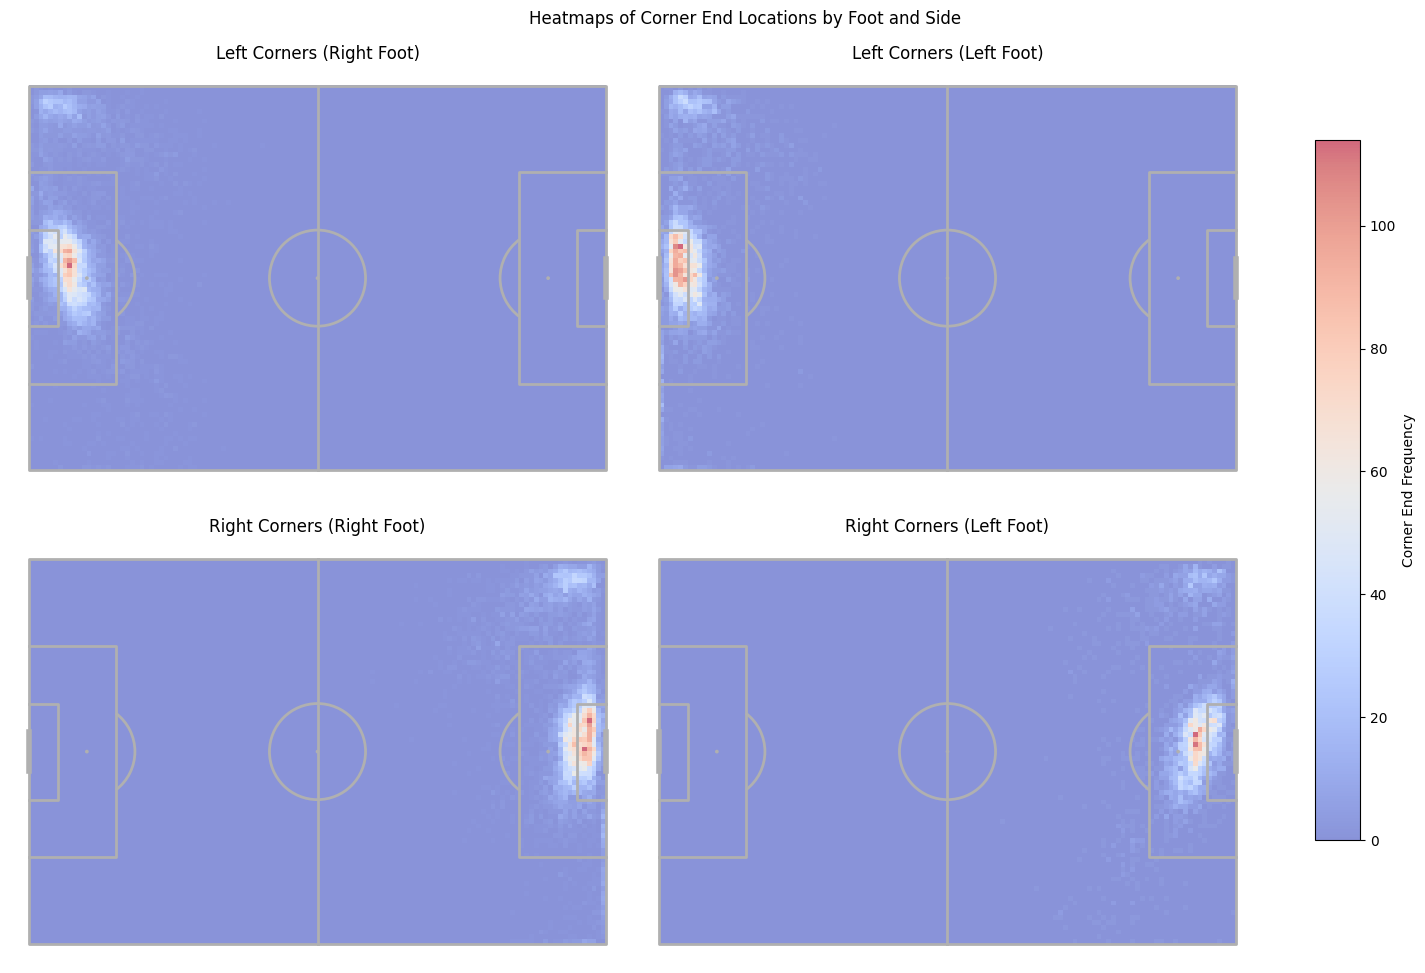

In [8]:
end_locations = {
    'left_right_foot': {'x': [], 'y': []},
    'left_left_foot': {'x': [], 'y': []},
    'right_right_foot': {'x': [], 'y': []},
    'right_left_foot': {'x': [], 'y': []}
}

# Loop through each corner pass and separate them by foot and side
for event in passes:
    # Get the starting location of the corner
    start_x, start_y = event['location']

    # Identify the foot used
    foot_used = event['pass']['body_part']['name'].lower() if 'body_part' in event['pass'] else 'unknown'

    # Corners from the left (either from 0,0 or 120,80)
    if  (start_x > 119 and start_y > 79):
        # Normalize coordinates if from 120,80
        end_x = 120 - event['pass']['end_location'][0]
        end_y = 80 - event['pass']['end_location'][1]

        if foot_used == 'right foot':
            end_locations['left_right_foot']['x'].append(end_x)
            end_locations['left_right_foot']['y'].append(end_y)
        elif foot_used == 'left foot':
            end_locations['left_left_foot']['x'].append(end_x)
            end_locations['left_left_foot']['y'].append(end_y)

    # Corners from the right (either from 0,80 or 120,0)
    elif (start_x > 119 and start_y < 1):
        end_x = event['pass']['end_location'][0]
        end_y =  event['pass']['end_location'][1]
        if foot_used == 'right foot':
            end_locations['right_right_foot']['x'].append(end_x)
            end_locations['right_right_foot']['y'].append(end_y)
        elif foot_used == 'left foot':
            end_locations['right_left_foot']['x'].append(end_x)
            end_locations['right_left_foot']['y'].append(end_y)


# Helper function to create heatmaps
def plot_heatmap(end_x, end_y, title, ax):
    heatmap_data, xedges, yedges = np.histogram2d(end_x, end_y, bins=[120, 80], range=[[0, 120], [0, 80]])
    pos = ax.imshow(heatmap_data.T, extent=[0, 120, 0, 80], origin='lower', cmap='coolwarm', alpha=0.6)
    ax.set_title(title)
    return pos


# Create the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_length=120, pitch_width=80)

# Set up the figure for 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Heatmaps of Corner End Locations by Foot and Side')

# Plot heatmaps for each side and foot
pos1 = plot_heatmap(end_locations['left_right_foot']['x'], end_locations['left_right_foot']['y'], 'Left Corners (Right Foot)', axs[0, 0])
pos2 = plot_heatmap(end_locations['left_left_foot']['x'], end_locations['left_left_foot']['y'], 'Left Corners (Left Foot)', axs[0, 1])
pos3 = plot_heatmap(end_locations['right_right_foot']['x'], end_locations['right_right_foot']['y'], 'Right Corners (Right Foot)', axs[1, 0])
pos4 = plot_heatmap(end_locations['right_left_foot']['x'], end_locations['right_left_foot']['y'], 'Right Corners (Left Foot)', axs[1, 1])

# Adjust the layout to place the color bar outside the subplots
plt.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # Color bar axis to the right of the plots
cbar = fig.colorbar(pos1, cax=cbar_ax)
cbar.set_label('Corner End Frequency')

# Draw the soccer field on each subplot
for ax in axs.flat:
    pitch.draw(ax=ax)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to leave space for the color bar
plt.show()

Indeed the Heatmap proof that right foot corners from the right resp. left foot corners from the left land more frequntly in the goal area, while right foot corners from the left resp. left foot corners from the right tend to land between penalty mark and goal area. Since from both sides more right foot corners are taken this explains the inbalance in the landing spot between right corners and left corners

## 2b) Use the 360 data for the few matches where they are available, to see if you can find effective defensive set-ups.

For this task I just analyze the set-ups during corners without taking into account the results of the corners. If I would have more time I could dig deeper in this regard but for now I anlyze based on the idea that what everybody else does must be good.\

### Analyzing the number of players in the box during a corner

In [12]:
corners_file = 'all_360_corners.json'


# Helper function to check if a player is inside a given rectangular area
def is_inside_box(location, box_corners):
    x, y = location
    (x1, y1), (x2, y2) = box_corners
    return x1 <= x <= x2 and y1 <= y <= y2


# Define the boxes and goal areas (as all corners are by statsbomb defintion are taken from the 120er length corner only the right boxes are relevant)
box_right = [(102, 18), (120, 62)]
box_left = [(0, 18), (18, 62)]
goal_area_right = [(114, 30), (120, 50)]
goal_area_left = [(0, 30), (6, 50)]

# Load the consolidated corner events data
with open(corners_file, 'r') as file:
    corners_data = json.load(file)


# Initialize counters
total_corners = 0
total_defensive_in_frame = 0
total_offensive_in_frame = 0
total_defensive_in_box = 0
total_offensive_in_box = 0
total_defensive_in_goal_area = 0
total_offensive_in_goal_area = 0

# Iterate over all the corner events in the consolidated file
for event in corners_data:
    total_corners += 1
    freeze_frame = event.get('freeze_frame', [])
    corner_location = event.get('location', [])

    # Initialize counters for the current event
    defensive_in_frame = 0
    offensive_in_frame = 0
    defensive_in_box = 0
    offensive_in_box = 0
    defensive_in_goal_area = 0
    offensive_in_goal_area = 0

    # Count players in various regions
    for player in freeze_frame:
        location = player['location']
        teammate = player['teammate']

        # Count offensive and defensive players in the frame
        if teammate:
            offensive_in_frame += 1
            if is_inside_box(location, box_right):
                offensive_in_box += 1
            if is_inside_box(location, goal_area_right):
                offensive_in_goal_area += 1
        else:
            defensive_in_frame += 1
            if is_inside_box(location, box_right):
                defensive_in_box += 1
            if is_inside_box(location, goal_area_right):
                defensive_in_goal_area += 1
    # Accumulate totals
    total_defensive_in_frame += defensive_in_frame
    total_offensive_in_frame += offensive_in_frame
    total_defensive_in_box += defensive_in_box
    total_offensive_in_box += offensive_in_box
    total_defensive_in_goal_area += defensive_in_goal_area
    total_offensive_in_goal_area += offensive_in_goal_area

avg_defensive_in_frame = total_defensive_in_frame / total_corners
avg_offensive_in_frame = total_offensive_in_frame / total_corners
avg_defensive_in_box = total_defensive_in_box / total_corners
avg_offensive_in_box = total_offensive_in_box / total_corners
avg_defensive_in_goal_area = total_defensive_in_goal_area / total_corners
avg_offensive_in_goal_area = total_offensive_in_goal_area / total_corners

print(f'Total number of corners: {total_corners}')

print(f"Average Defensive Players in Frame: {avg_defensive_in_frame}")
print(f"Average Offensive Players in Frame: {avg_offensive_in_frame}")
print(f"Average Defensive Players in Box: {avg_defensive_in_box}")
print(f"Average Offensive Players in Box: {avg_offensive_in_box}")
print(f"Average Defensive Players in Goal Area: {avg_defensive_in_goal_area}")
print(f"Average Offensive Players in Goal Area: {avg_offensive_in_goal_area}")

Total number of corners: 1738
Average Defensive Players in Frame: 10.558112773302646
Average Offensive Players in Frame: 8.143843498273878
Average Defensive Players in Box: 9.823935558112773
Average Offensive Players in Box: 5.441887226697354
Average Defensive Players in Goal Area: 5.002876869965478
Average Offensive Players in Goal Area: 1.5701956271576525


It becomes clear that from a defensive perspective it is impotant to have many players in the box and especially in the goal area

### Analyzing the positions of the defensive players during a corner

10001


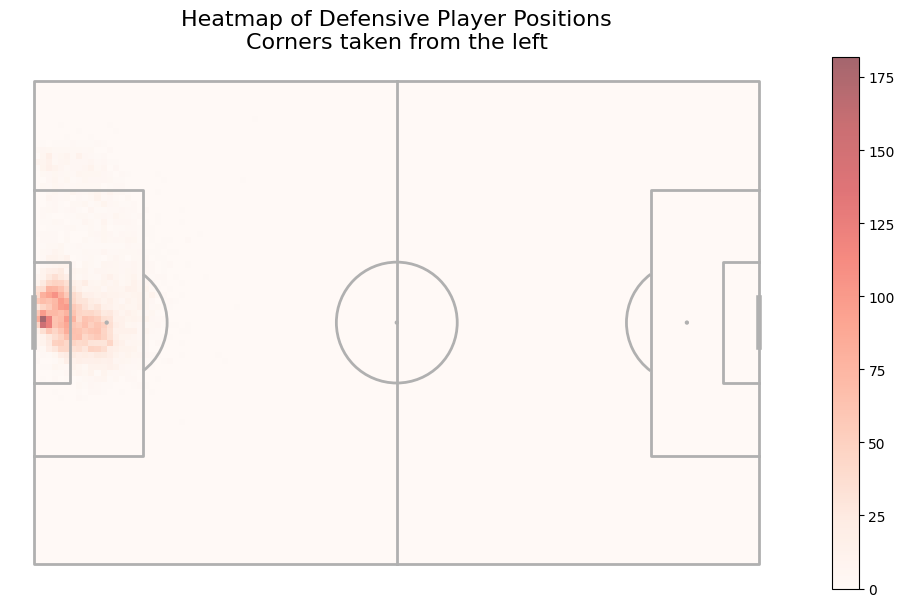

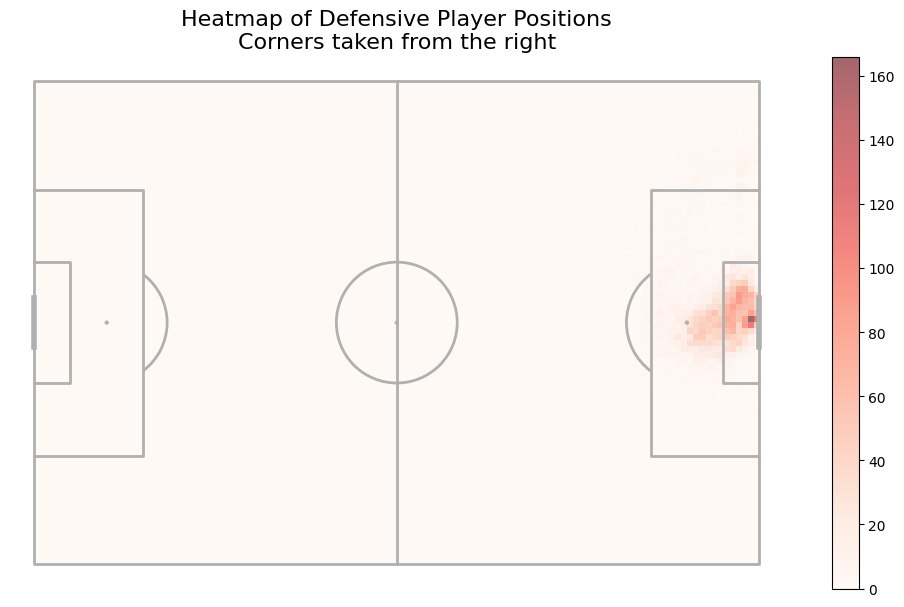

In [15]:
# Initialize lists to store defensive player positions
# Initialize lists to store defensive player positions
defensive_positions_left_x = []
defensive_positions_left_y = []
defensive_positions_right_x = []
defensive_positions_right_y = []

# Loop through the corner events and collect defensive player positions
for event in corners_data:
    freeze_frame = event.get('freeze_frame', [])
    corner_location = event.get('location', [])

    # Determine the side of the corner and collect defensive player positions
    if corner_location == [120, 0.1]:  # Right corner
        for player in freeze_frame:
            if not player['teammate']:  # Defensive player
                defensive_positions_right_x.append(player['location'][0])
                defensive_positions_right_y.append(player['location'][1])

    elif corner_location == [120, 80]:  # Left corner
        for player in freeze_frame:
            if not player['teammate']:  # Defensive player
                defensive_positions_left_x.append(120-player['location'][0])
                defensive_positions_left_y.append(80-player['location'][1])

# Create heatmap data using numpy's 2D histogram for left corners
print(len(defensive_positions_left_x))
left_heatmap_data, xedges_left, yedges_left = np.histogram2d(defensive_positions_left_x, defensive_positions_left_y,
                                                             bins=[120, 80], range=[[0, 120], [0, 80]])

# Create heatmap data using numpy's 2D histogram for right corners
right_heatmap_data, xedges_right, yedges_right = np.histogram2d(defensive_positions_right_x,
                                                                defensive_positions_right_y, bins=[120, 80],
                                                                range=[[0, 120], [0, 80]])

# Initialize the pitch for plotting
pitch = Pitch(pitch_type='statsbomb', pitch_length=120, pitch_width=80)  # Create the soccer field

# Plot heatmap for corners taken from the left
fig_left, ax_left = pitch.draw(figsize=(10, 6))  # Create the figure and axis for the pitch
pos_left = ax_left.imshow(left_heatmap_data.T, extent=[0, 120, 0, 80], origin='lower', cmap='Reds', alpha=0.6)
ax_left.set_title("Heatmap of Defensive Player Positions\nCorners taken from the left", fontsize=16)
plt.colorbar(pos_left, ax=ax_left)

# Plot heatmap for corners taken from the right
fig_right, ax_right = pitch.draw(figsize=(10, 6))  # Create the figure and axis for the pitch
pos_right = ax_right.imshow(right_heatmap_data.T, extent=[0, 120, 0, 80], origin='lower', cmap='Reds', alpha=0.6)
ax_right.set_title("Heatmap of Defensive Player Positions\nCorners taken from the right", fontsize=16)
plt.colorbar(pos_right, ax=ax_right)
plt.show()

It becomes clear that should 1-2 player at or in front of the near post in the goal area, another 2-3 players (including the goalkeeper) in the goal area between the near and far post. The remaining defensive player should be penalty mark and goal box but more orientated to the far post. Moreover, from the data ist looks most defensive players are behind the imaginary line between the penalty mark and corner of the goal box and goal line at the near post

### Deep-Dive into the positioning of the players

For the analysis of the positions we divide the box further as shown below

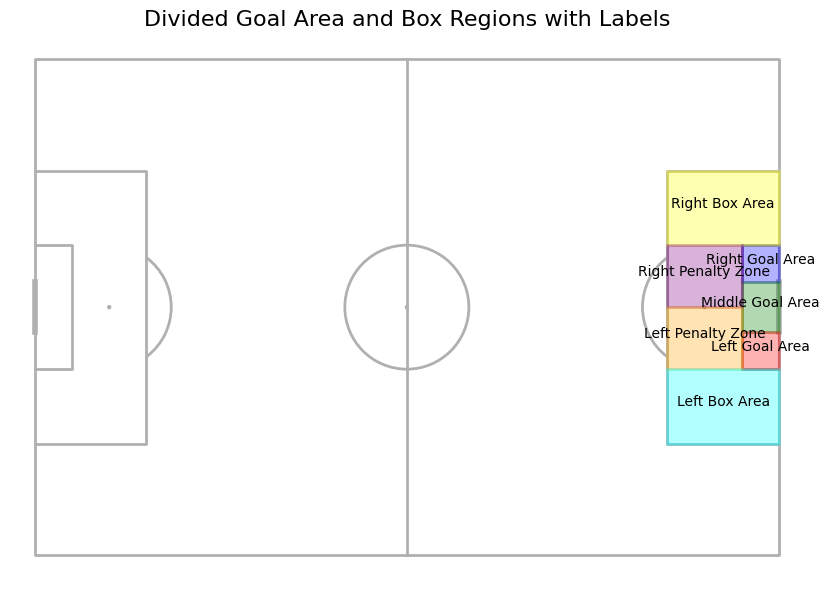

In [19]:
# Initialize the pitch for plotting
pitch = Pitch(pitch_type='statsbomb', pitch_length=120, pitch_width=80)

# Create the figure and axis for the pitch
fig, ax = pitch.draw(figsize=(10, 6))

# Define and plot the goal areas
# Right goal area: (114, 30) to (120, 36)
right_goal_area = Rectangle((114, 30), 6, 6, linewidth=2, edgecolor='blue', facecolor='blue', alpha=0.3)
ax.add_patch(right_goal_area)
ax.text(117, 33, "Right Goal Area", color='black', fontsize=10, ha='center')

# Middle goal area: (114, 36) to (120, 44)
middle_goal_area = Rectangle((114, 36), 6, 8, linewidth=2, edgecolor='green', facecolor='green', alpha=0.3)
ax.add_patch(middle_goal_area)
ax.text(117, 40, "Middle Goal Area", color='black', fontsize=10, ha='center')

# Left goal area: (114, 44) to (120, 50)
left_goal_area = Rectangle((114, 44), 6, 6, linewidth=2, edgecolor='red', facecolor='red', alpha=0.3)
ax.add_patch(left_goal_area)
ax.text(117, 47, "Left Goal Area", color='black', fontsize=10, ha='center')

# Define and plot the box areas
# Right box area: (102, 18) to (120, 30)
right_box_area = Rectangle((102, 18), 18, 12, linewidth=2, edgecolor='yellow', facecolor='yellow', alpha=0.3)
ax.add_patch(right_box_area)
ax.text(111, 24, "Right Box Area", color='black', fontsize=10, ha='center')

# Right penalty zone: (102, 30) to (114, 40)
right_penalty_zone = Rectangle((102, 30), 12, 10, linewidth=2, edgecolor='purple', facecolor='purple', alpha=0.3)
ax.add_patch(right_penalty_zone)
ax.text(108, 35, "Right Penalty Zone", color='black', fontsize=10, ha='center')

# Left penalty zone: (102, 40) to (114, 50)
left_penalty_zone = Rectangle((102, 40), 12, 10, linewidth=2, edgecolor='orange', facecolor='orange', alpha=0.3)
ax.add_patch(left_penalty_zone)
ax.text(108, 45, "Left Penalty Zone", color='black', fontsize=10, ha='center')

# Left box area: (102, 50) to (120, 62)
left_box_area = Rectangle((102, 50), 18, 12, linewidth=2, edgecolor='cyan', facecolor='cyan', alpha=0.3)
ax.add_patch(left_box_area)
ax.text(111, 56, "Left Box Area", color='black', fontsize=10, ha='center')

# Add a title
ax.set_title("Divided Goal Area and Box Regions with Labels", fontsize=16)

# Show the plot
plt.show()

Based on this areas we can analyze the positioning of the defensive players further

In [20]:
def is_inside_box(location, box_corners):
    x, y = location
    (x1, y1), (x2, y2) = box_corners
    return x1 <= x <= x2 and y1 <= y <= y2


# Define the zones
zones = {
    'right_goal_area': [(114, 30), (120, 36)],
    'middle_goal_area': [(114, 36), (120, 44)],
    'left_goal_area': [(114, 44), (120, 50)],
    'right_box_area': [(102, 18), (120, 30)],
    'right_penalty_zone': [(102, 30), (114, 40)],
    'left_penalty_zone': [(102, 40), (114, 50)],
    'left_box_area': [(102, 50), (120, 62)]
}

# Initialize counters
defensive_counts_left = {zone: 0 for zone in zones}  # For left corners
defensive_counts_right = {zone: 0 for zone in zones}  # For right corners
left_corner_count = 0
right_corner_count = 0

# Loop through the corner events and count defensive players in each zone
for event in corners_data:
    freeze_frame = event.get('freeze_frame', [])
    corner_location = event.get('location', [])

    # Check if it's a left or right corner
    if corner_location == [120, 0.1]:  # Right corner
        right_corner_count += 1
        for player in freeze_frame:
            if not player['teammate']:  # Defensive player
                player_location = player['location']

                # Check if the player is inside any of the defined zones
                for zone_name, (bottom_left, top_right) in zones.items():
                    if is_inside_box(player_location, (bottom_left, top_right)):
                        defensive_counts_right[zone_name] += 1

    elif corner_location == [120, 80]:  # Left corner
        left_corner_count += 1
        for player in freeze_frame:
            if not player['teammate']:  # Defensive player
                player_location = player['location']

                # Check if the player is inside any of the defined zones
                for zone_name, (bottom_left, top_right) in zones.items():
                    if is_inside_box(player_location, (bottom_left, top_right)):
                        defensive_counts_left[zone_name] += 1


# Calculate averages
def calculate_average(counts, total_corners):
    if total_corners == 0:
        return {zone: 0 for zone in counts}  # Avoid division by zero
    return {zone: counts[zone] / total_corners for zone in counts}


average_defensive_left = calculate_average(defensive_counts_left, left_corner_count)
average_defensive_right = calculate_average(defensive_counts_right, right_corner_count)

# Print the results
print(f"Total left corners: {left_corner_count}")
print("Average Number of Defensive Players in Each Zone During Left Corners:")
for zone, avg in average_defensive_left.items():
    print(f"{zone}: {avg:.2f}")

print(f"\nTotal right corners: {right_corner_count}")
print("Average Number of Defensive Players in Each Zone During Right Corners:")
for zone, avg in average_defensive_right.items():
    print(f"{zone}: {avg:.2f}")

Total left corners: 946
Average Number of Defensive Players in Each Zone During Left Corners:
right_goal_area: 0.25
middle_goal_area: 3.30
left_goal_area: 1.30
right_box_area: 0.03
right_penalty_zone: 2.50
left_penalty_zone: 1.92
left_box_area: 0.54

Total right corners: 792
Average Number of Defensive Players in Each Zone During Right Corners:
right_goal_area: 1.40
middle_goal_area: 3.53
left_goal_area: 0.26
right_box_area: 0.62
right_penalty_zone: 1.74
left_penalty_zone: 2.22
left_box_area: 0.04


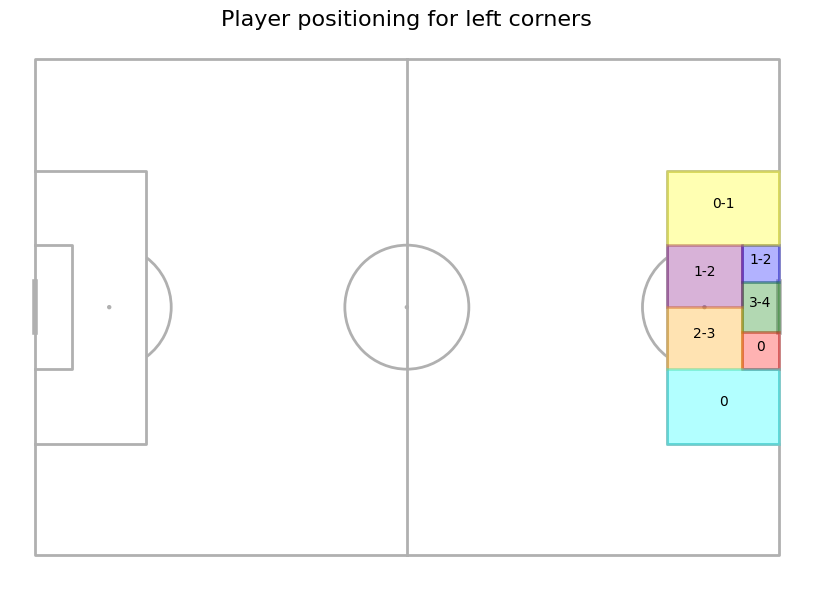

In [22]:
# Initialize the pitch for plotting
pitch = Pitch(pitch_type='statsbomb', pitch_length=120, pitch_width=80)

# Create the figure and axis for the pitch
fig, ax = pitch.draw(figsize=(10, 6))

# Define and plot the goal areas
# Right goal area: (114, 30) to (120, 36)
right_goal_area = Rectangle((114, 30), 6, 6, linewidth=2, edgecolor='blue', facecolor='blue', alpha=0.3)
ax.add_patch(right_goal_area)
ax.text(117, 33, "1-2", color='black', fontsize=10, ha='center')

# Middle goal area: (114, 36) to (120, 44)
middle_goal_area = Rectangle((114, 36), 6, 8, linewidth=2, edgecolor='green', facecolor='green', alpha=0.3)
ax.add_patch(middle_goal_area)
ax.text(117, 40, "3-4", color='black', fontsize=10, ha='center')

# Left goal area: (114, 44) to (120, 50)
left_goal_area = Rectangle((114, 44), 6, 6, linewidth=2, edgecolor='red', facecolor='red', alpha=0.3)
ax.add_patch(left_goal_area)
ax.text(117, 47, "0", color='black', fontsize=10, ha='center')

# Define and plot the box areas
# Right box area: (102, 18) to (120, 30)
right_box_area = Rectangle((102, 18), 18, 12, linewidth=2, edgecolor='yellow', facecolor='yellow', alpha=0.3)
ax.add_patch(right_box_area)
ax.text(111, 24, "0-1", color='black', fontsize=10, ha='center')

# Right penalty zone: (102, 30) to (114, 40)
right_penalty_zone = Rectangle((102, 30), 12, 10, linewidth=2, edgecolor='purple', facecolor='purple', alpha=0.3)
ax.add_patch(right_penalty_zone)
ax.text(108, 35, "1-2", color='black', fontsize=10, ha='center')

# Left penalty zone: (102, 40) to (114, 50)
left_penalty_zone = Rectangle((102, 40), 12, 10, linewidth=2, edgecolor='orange', facecolor='orange', alpha=0.3)
ax.add_patch(left_penalty_zone)
ax.text(108, 45, "2-3", color='black', fontsize=10, ha='center')

# Left box area: (102, 50) to (120, 62)
left_box_area = Rectangle((102, 50), 18, 12, linewidth=2, edgecolor='cyan', facecolor='cyan', alpha=0.3)
ax.add_patch(left_box_area)
ax.text(111, 56, "0", color='black', fontsize=10, ha='center')

# Add a title
ax.set_title("Player positioning for left corners", fontsize=16)

# Show the plot
plt.show()

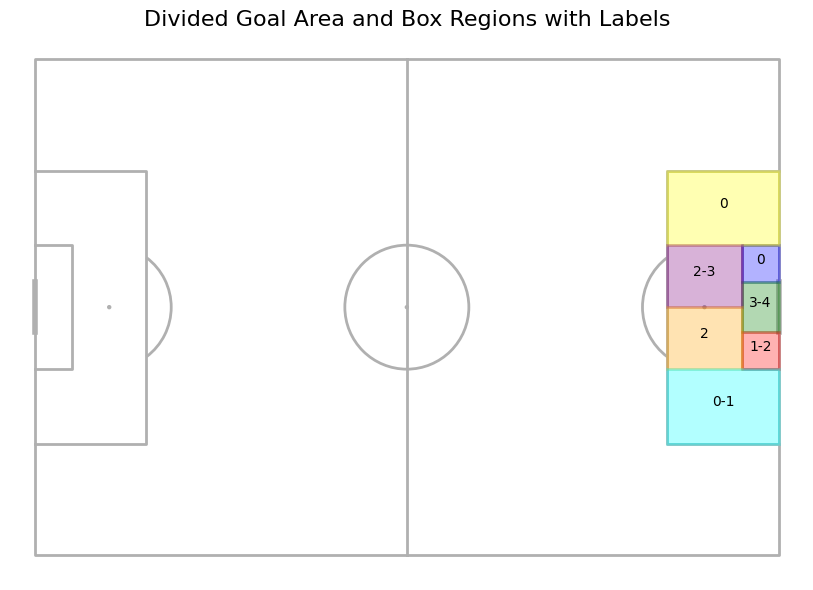

In [21]:
# Initialize the pitch for plotting
pitch = Pitch(pitch_type='statsbomb', pitch_length=120, pitch_width=80)

# Create the figure and axis for the pitch
fig, ax = pitch.draw(figsize=(10, 6))

# Define and plot the goal areas
# Right goal area: (114, 30) to (120, 36)
right_goal_area = Rectangle((114, 30), 6, 6, linewidth=2, edgecolor='blue', facecolor='blue', alpha=0.3)
ax.add_patch(right_goal_area)
ax.text(117, 33, "0", color='black', fontsize=10, ha='center')

# Middle goal area: (114, 36) to (120, 44)
middle_goal_area = Rectangle((114, 36), 6, 8, linewidth=2, edgecolor='green', facecolor='green', alpha=0.3)
ax.add_patch(middle_goal_area)
ax.text(117, 40, "3-4", color='black', fontsize=10, ha='center')

# Left goal area: (114, 44) to (120, 50)
left_goal_area = Rectangle((114, 44), 6, 6, linewidth=2, edgecolor='red', facecolor='red', alpha=0.3)
ax.add_patch(left_goal_area)
ax.text(117, 47, "1-2", color='black', fontsize=10, ha='center')

# Define and plot the box areas
# Right box area: (102, 18) to (120, 30)
right_box_area = Rectangle((102, 18), 18, 12, linewidth=2, edgecolor='yellow', facecolor='yellow', alpha=0.3)
ax.add_patch(right_box_area)
ax.text(111, 24, "0", color='black', fontsize=10, ha='center')

# Right penalty zone: (102, 30) to (114, 40)
right_penalty_zone = Rectangle((102, 30), 12, 10, linewidth=2, edgecolor='purple', facecolor='purple', alpha=0.3)
ax.add_patch(right_penalty_zone)
ax.text(108, 35, "2-3", color='black', fontsize=10, ha='center')

# Left penalty zone: (102, 40) to (114, 50)
left_penalty_zone = Rectangle((102, 40), 12, 10, linewidth=2, edgecolor='orange', facecolor='orange', alpha=0.3)
ax.add_patch(left_penalty_zone)
ax.text(108, 45, "2", color='black', fontsize=10, ha='center')

# Left box area: (102, 50) to (120, 62)
left_box_area = Rectangle((102, 50), 18, 12, linewidth=2, edgecolor='cyan', facecolor='cyan', alpha=0.3)
ax.add_patch(left_box_area)
ax.text(111, 56, "0-1", color='black', fontsize=10, ha='center')

# Add a title
ax.set_title("Player positioning for left corners", fontsize=16)

# Show the plot
plt.show()

## Summary


This analysis gives a basis understanding and overview of corners in professional soccer. In the first part some general trend were identified. Especially rreagrding the end location of the corner we identified interesting insights such as that right corners more frequently in the goal area than left corners. We also identidied the reason for this as more right footers take corners.\
In the second part, we idnetified how many defensive players should be in the areas of the penalty box.  

## Limitations

Obviously this analysis is only a brief overview of what is possible and has several limitatons that could be improved with more time (and more data). For exmaple
1) I am sure there is much more interesting insights hidden reagrding offensive trends. For example it would be very interesting to use position data to see general offensive positioning trends but also at which situations of a match which type of corners are used, etc.
2) Both during the offensive and defensive analysis i disregarded the results of the corners. I would be interesting to see which corners lead to offensive and defensive success
3) I also disregarded the offensive players in the analysis of the positioning of the defensive players. This obviously is not realistic as the defensive schema should at least to a certain extent depend on the offensive positioning during corners 